In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pyfar as pf
import soundfile as sf

In [6]:
###### prepare multi-channel audio
audio, sr = sf.read('Mister Magic.flac')
time_len = 2 * 60  # truncate all instrument to 2 min
audio = audio[:time_len * sr, :]

IndentationError: unexpected indent (1925117739.py, line 7)

In [7]:
############ Virtual Surround Sound ##################

In [3]:
def surround_2_bin(surround_sound, audio):
    # summing up channel and normalize value from 0~surround_max to 0~audio_max
    binaural_downmix = np.vstack((sum(surround_sound['left']), sum(surround_sound['right'])))
    binaural_downmix = binaural_downmix * np.amax(audio) / np.amax(binaural_downmix)

    return binaural_downmix

In [4]:
def vss(hrir, audio):
    surround_sound = {}
    surround_sound['left'] = []
    surround_sound['right'] = []
    for loc, ir in hrir.items():
        surround_sound['left'].append(np.convolve(audio[:, 0], ir[0, :]))
        surround_sound['right'].append(np.convolve(audio[:, 1], ir[1, :]))

    binaural_downmix = surround_2_bin(surround_sound, audio)

    return binaural_downmix


In [6]:
def object_vss(hrir, music):
    surround_sound = {}
    surround_sound['left'] = []
    surround_sound['right'] = []
    # guitar in the front (left, right, center)
    surround_sound['left'].append(np.convolve(music['guitar_l'], hrir['ls'][0, :]))
    surround_sound['left'].append(np.convolve(music['guitar_l'], hrir['rs'][0, :]))
    surround_sound['left'].append(np.convolve(music['guitar_l'], hrir['cs'][0, :]))
    surround_sound['right'].append(np.convolve(music['guitar_r'], hrir['ls'][1, :]))
    surround_sound['right'].append(np.convolve(music['guitar_r'], hrir['rs'][1, :]))
    surround_sound['right'].append(np.convolve(music['guitar_r'], hrir['cs'][1, :]))
    # drum in the back (left/right rear surround)
    surround_sound['left'].append(np.convolve(music['drum_l'], hrir['lrss'][0, :]))
    surround_sound['left'].append(np.convolve(music['drum_l'], hrir['rrss'][0, :]))
    surround_sound['right'].append(np.convolve(music['drum_r'], hrir['lrss'][1, :]))
    surround_sound['right'].append(np.convolve(music['drum_r'], hrir['rrss'][1, :]))
    # bass in subwoofer
    surround_sound['left'].append(np.convolve(music['bass_l'], hrir['sub'][0, :]))
    surround_sound['right'].append(np.convolve(music['bass_r'], hrir['sub'][1, :]))
    # other in center overhead and side (right/left surround, top rear overhead)
    surround_sound['left'].append(np.convolve(music['other_l'], hrir['lss'][0, :]))
    surround_sound['left'].append(np.convolve(music['other_l'], hrir['rss'][0, :]))
    surround_sound['left'].append(np.convolve(music['other_l'], hrir['ltfos'][0, :]))
    surround_sound['left'].append(np.convolve(music['other_l'], hrir['rtfo'][0, :]))
    surround_sound['left'].append(np.convolve(music['other_l'], hrir['ltros'][0, :]))
    surround_sound['left'].append(np.convolve(music['other_l'], hrir['rtros'][0, :]))
    surround_sound['right'].append(np.convolve(music['other_r'], hrir['lss'][1, :]))
    surround_sound['right'].append(np.convolve(music['other_r'], hrir['rss'][1, :]))
    surround_sound['right'].append(np.convolve(music['other_r'], hrir['ltfos'][1, :]))
    surround_sound['left'].append(np.convolve(music['other_r'], hrir['rtfo'][1, :]))
    surround_sound['left'].append(np.convolve(music['other_r'], hrir['ltros'][1, :]))
    surround_sound['left'].append(np.convolve(music['other_r'], hrir['rtros'][1, :]))

    binaural_downmix = surround_2_bin(surround_sound, audio)

    return binaural_downmix

SOFA file contained custom entries
----------------------------------
GLOBAL_RoomShortName, GLOBAL_RoomDescription, GLOBAL_RoomLocation, GLOBAL_ListenerDescription, GLOBAL_SourceShortName, GLOBAL_SourceDescription, GLOBAL_ReceiverShortName, GLOBAL_ReceiverDescription, GLOBAL_EmitterShortName, GLOBAL_EmitterDescription, GLOBAL_URL, GLOBAL_RoomVolume, RoomVolume, RoomVolume_Units


In [10]:
############ utils ###############

In [14]:
def db_to_amp(x):
    return 10 ** (x / 20)


def minus_db(signal, db):
    out = signal * ((np.amax(signal) - db_to_amp(db)) / np.amax(signal))
    return out


def test(source_coordinates, data_ir):
    # inspecting HRIR
    index, _ = source_coordinates.find_nearest_k(
        90, 0, 0.09, k=1, domain='sph', convention='top_elev', unit='deg', show=True)  # receiver radius is 0.09m
    _, mask = source_coordinates.find_slice(
        'elevation', unit='deg', value=0, show=True)
    pf.plot.time_freq(data_ir[index])
    with pf.plot.context():
        plt.subplots(2, 1, figsize=(8, 6), sharex=True)
        angles = source_coordinates.get_sph('top_elev', 'deg')[mask, 0]
        ax, qm, cb = pf.plot.time_freq_2d(data_ir[mask, 0], indices=angles,
                                          cmap=mpl.cm.get_cmap(name='coolwarm'))
        ax[0].set_title("Left ear HRIR (Horizontal plane)")
        ax[0].set_xlabel("")
        ax[0].set_ylim(0, 3)
        qm[0].set_clim(-1.5, 1.5)
        ax[1].set_title("Left ear HRTFs (Horizontal plane)")
        ax[1].set_xlabel("Azimuth angle in degrees")
        ax[1].set_ylim(200, 20e3)
        qm[1].set_clim(-25, 25)
        plt.tight_layout()


def get_ir(source_coordinates, data_ir):
    # all measurements are done at distance 2.06m with (azimuth, elevation, radius)
    location = ['ls', 'rs', 'cs', 'sub', 'lss', 'rss', 'lrss', 'rrss', 'ltfos', 'rtfo', 'ltros', 'rtros']
    azimuth = [30, 330, 0, 20, 90, 270, 150, 210, 45, 315, 135, 225]
    elevation = [0, 0, 0, -30, 0, 0, 0, 0, 45, 45, 45, 45]
    # Left and right speakers ( 30, 0) (330, 0)
    # Center speaker (0, 0)
    # Subwoofer (20,  -30)
    # Left and right surround speakers (90, 0) (270, 0)
    # Left and right rear surround speakers (150, 0) (210, 0)
    # Left and right top front overhead speakers (45, 45) (315, 45)
    # Left and right top rear overhead speakers (135, 45) (225, 45)
    hrir = {}
    for i, loc in enumerate(location):
        index = source_coordinates.find_nearest_k(
            azimuth[i], elevation[i], 2.06, k=1, domain='sph', convention='top_elev', unit='deg')[0]
        print(loc, index, source_coordinates.cartesian[index])
        hrir[loc] = data_ir[index].time.T
    return hrir


def get_music():
    # audio separation is done by studio.gaudiolab.io
    time_len = 2 * 60  # truncate all instrument to 2 min

    music = {}
    for item in ['bass', 'drum', 'guitar', 'other']:
        instr, sr = sf.read(item + '.mp3')
        music[item + '_l'] = instr[:time_len * sr, 0]
        music[item + '_r'] = instr[:time_len * sr, 1]

    return music

In [15]:
############ Stereo downmix ###############

In [16]:
def stereo_mix(audio):
    """
    The downmixing principle of this function refers to https://professionalsupport.dolby.com/s/article/How-do-the-5-1-and-Stereo-downmix-settings-work?language=en_US
    From 7.1 to 5.1:
    Ls = Lss + (–1.2 dB × Lrs) + (–6.2 dB × Rrs)
    Rs = Rss + (–6.2 dB × Lrs) + (–1.2 dB × Rrs)
    From 5.1 to stereo:
    Lt = L + (–3 dB × C) – (–1.2 dB × Ls) – (–6.2 dB × Rs)
    Rt = R + (–3 dB × C) + (–6.2 dB × Ls) + (–1.2 dB × Rs)
    And let's assume left channels are put to left speakers, right channels in right speakers and left at center too.

    :param audio:
    :return:
    """
    left = audio[:, 0]
    right = audio[:, 1]
    # downmix 7.1 to 5.1
    ls = left + minus_db(left, 1.2) + minus_db(left, 6.2)
    rs = right + minus_db(right, 6.2) + minus_db(right, 1.2)

    # downmix 5.1 to stereo
    l = left + minus_db(left, 3) - minus_db(ls, 1.2) - minus_db(rs, 6.2)
    r = right + minus_db(left, 3) - minus_db(ls, 6.2) - minus_db(rs, 1.2)

    stereo = np.vstack((l, r))
    stereo = stereo * np.amax(audio) / np.amax(stereo)
    return stereo

In [17]:
############ running #############

SOFA file contained custom entries
----------------------------------
GLOBAL_RoomShortName, GLOBAL_RoomDescription, GLOBAL_RoomLocation, GLOBAL_ListenerDescription, GLOBAL_SourceShortName, GLOBAL_SourceDescription, GLOBAL_ReceiverShortName, GLOBAL_ReceiverDescription, GLOBAL_EmitterShortName, GLOBAL_EmitterDescription, GLOBAL_URL, GLOBAL_RoomVolume, RoomVolume, RoomVolume_Units
ls 74 [1.78401233 1.03       0.        ]
rs 94 [ 1.78401233 -1.03        0.        ]
cs 72 [2.06 0.   0.  ]
sub 25 [ 1.72322359  0.46173637 -1.03      ]
lss 78 [0.   2.06 0.  ]
rss 90 [-3.78415861e-16 -2.06000000e+00  0.00000000e+00]
lrss 82 [-1.78401233  1.03        0.        ]
rrss 86 [-1.78401233 -1.03        0.        ]
ltfos 147 [1.03       1.03       1.45663997]
rtfo 165 [ 1.03       -1.03        1.45663997]
ltros 153 [-1.03        1.03        1.45663997]
rtros 159 [-1.03       -1.03        1.45663997]


/Users/sivanding/opt/miniconda3/envs/seld/lib/python3.8/site-packages/pyfar/classes/coordinates.py:1769: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of find_nearest method.'
  warnings.warn((
/Users/sivanding/opt/miniconda3/envs/seld/lib/python3.8/site-packages/pyfar/classes/coordinates.py:136: PyfarDeprecationWarning: 'This function will be changed in pyfar 0.8.0 to init(x, y, z).'
  warnings.warn((
/Users/sivanding/opt/miniconda3/envs/seld/lib/python3.8/site-packages/pyfar/classes/coordinates.py:606: PyfarDeprecationWarning: "'deg' parameter will be deprecated in pyfar 0.8.0 in favor of the pyfar.deg2rad and pyfar.rad2deg"
  warnings.warn((
/Users/sivanding/opt/miniconda3/envs/seld/lib/python3.8/site-packages/pyfar/classes/coordinates.py:2003: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0. Use properties and slicing instead.'
  warnings.warn((
/Users/sivanding/opt/miniconda3/envs/seld/lib/python3.8/site-packages/pyfar

RuntimeError: Colorbar layout of new layout engine not compatible with old engine, and a colorbar has been created.  Engine not changed.

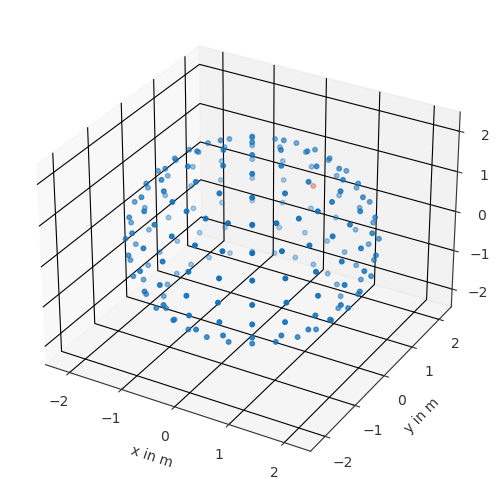

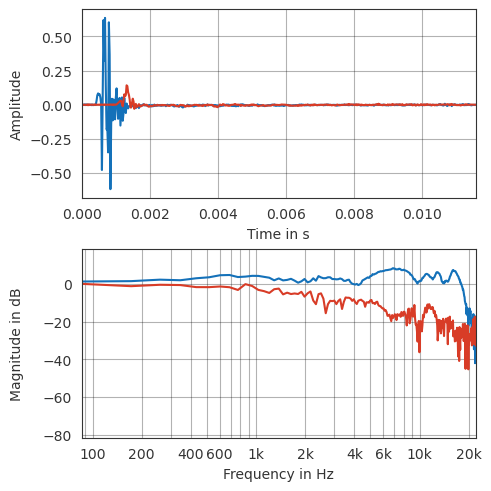

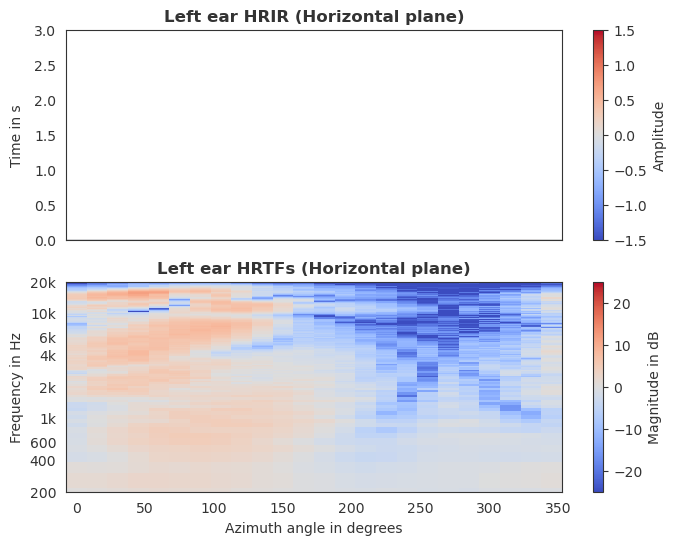

In [18]:
###### prepare two channel HRTF at different locations (azimuth, elevation) of dolby 7.1.4 layout:
data_ir, source_coordinates, receiver_coordinates = pf.io.read_sofa(
    'IRC_1003_C_44100.sofa')
hrir = get_ir(source_coordinates, data_ir)

test(source_coordinates, data_ir)
